In [1]:
import urllib.request
import zipfile
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam


In [2]:
class ModelCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96:
      self.model.stop_training = True

In [3]:
data_url = 'https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip'
urllib.request.urlretrieve(data_url, 'rockpaperscissors.zip')
local_file = 'rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('data/')
zip_ref.close()

In [4]:
training_dir = 'data/rockpaperscissors/rps-cv-images'
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest'
)

train_generator = training_datagen.flow_from_directory(
    training_dir,
    color_mode="grayscale",
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='training'
)

validation_generator = training_datagen.flow_from_directory(
    training_dir,
    color_mode="grayscale",
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    subset='validation'
)


Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


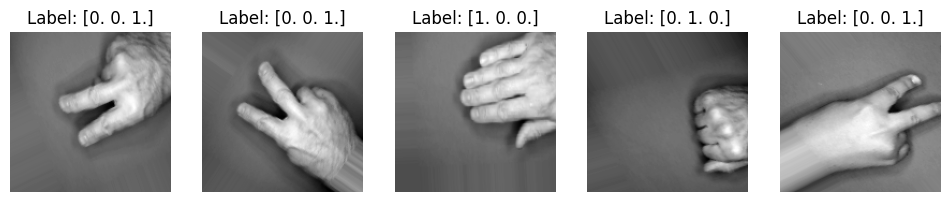

In [5]:
import matplotlib.pyplot as plt

# Ambil satu batch gambar dari train_generator
batch = next(train_generator)

# Pisahkan gambar dan label
images, labels = batch

# Tampilkan beberapa gambar dari batch tersebut
plt.figure(figsize=(12, 6))
for i in range(5):  # Menampilkan 5 gambar pertama dari batch
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Label: {labels[i]}')  # Menampilkan label pada gambar
    plt.axis('off')

plt.show()


In [6]:
model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(150, 150, 1)),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2, 2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(3, activation='softmax')
])

In [7]:
def lr_schedule(epoch):
    learning_rate = 0.0003
    if epoch > 50:
        learning_rate *= 0.1
    return learning_rate

In [8]:
optimizer = Adam() # learning rate diatur di lr_schedule
loss_function = 'categorical_crossentropy'

model.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy']
)

stop_callback = ModelCallback()
lr_callback = LearningRateScheduler(lr_schedule)

callbacks_list = [lr_callback, stop_callback]


model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks_list
)

model.save('rock_paper_scissors_model.h5')

Epoch 1/100
11/11 [==============================] - 27s 1s/step - loss: 1.1027 - accuracy: 0.3349 - val_loss: 1.0962 - val_accuracy: 0.3432 - lr: 3.0000e-04
Epoch 2/100
11/11 [==============================] - 9s 876ms/step - loss: 1.0971 - accuracy: 0.3775 - val_loss: 1.0948 - val_accuracy: 0.3432 - lr: 3.0000e-04
Epoch 3/100
11/11 [==============================] - 9s 871ms/step - loss: 1.0943 - accuracy: 0.4102 - val_loss: 1.0882 - val_accuracy: 0.4645 - lr: 3.0000e-04
Epoch 4/100
11/11 [==============================] - 11s 1s/step - loss: 1.0738 - accuracy: 0.4566 - val_loss: 1.0558 - val_accuracy: 0.5069 - lr: 3.0000e-04
Epoch 5/100
11/11 [==============================] - 11s 967ms/step - loss: 1.0065 - accuracy: 0.5038 - val_loss: 0.9418 - val_accuracy: 0.6350 - lr: 3.0000e-04
Epoch 6/100
11/11 [==============================] - 9s 867ms/step - loss: 0.8985 - accuracy: 0.5860 - val_loss: 0.8364 - val_accuracy: 0.7208 - lr: 3.0000e-04
Epoch 7/100
11/11 [========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saving paper_1.png to paper_1 (3).png
1/1 [==============================] - 0s 78ms/step
paper_1 (3).png
Prediction: paper


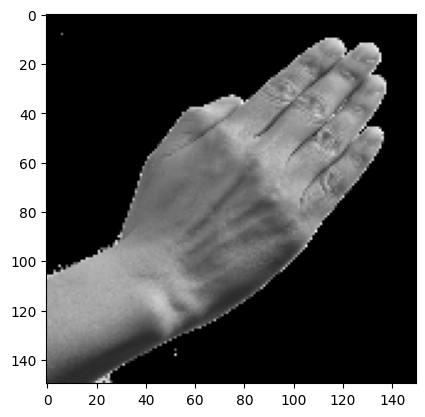

In [15]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2  # Untuk konversi RGB ke Grayscale
%matplotlib inline

uploaded = files.upload()

model = tf.keras.models.load_model('rock_paper_scissors_model.h5')

for fn in uploaded.keys():
    # Load gambar RGB yang diunggah
    path = fn
    rgb_img = mpimg.imread(path)

    # Ubah gambar RGB menjadi grayscale
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)

    # Ubah ukuran gambar sesuai dengan yang diharapkan oleh model
    target_size = (150, 150)
    gray_img = cv2.resize(gray_img, target_size)

    imgplot = plt.imshow(gray_img, cmap='gray')  # Tampilkan gambar grayscale
    x = image.img_to_array(gray_img)
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    classes = model.predict(images, batch_size=10)

    # Menentukan hasil klasifikasi berdasarkan nilai probabilitas tertinggi
    class_labels = ["paper", "rock",  "scissors"]
    predicted_class = class_labels[np.argmax(classes)]

    print(fn)
    print("Prediction:", predicted_class)
